# **WallStreetBets DD Recommender**
## Notebook for Data Visualization

In [1]:
"""
!!! Do not execute this cell with jupyter notebook
"""
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install pyspark
!pip install yellowbrick

     |████████████████████████████████| 212.3MB 71kB/s 
     |████████████████████████████████| 204kB 9.9MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=3a268ea6ab8dd4abe637da3531cc82d4c24392770098b79c278e0b4c7951cc05
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


### Import libraries for Clustering

In [2]:
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark import SparkContext as sc
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import udf,col
import random
import numpy as np

In [3]:
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix
from sklearn import decomposition

### Data preprocessing: Remove stop words and feature extraction

In [4]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Python Spark Clustering with scikit-learn") \
        .getOrCreate()
    return spark
spark = init_spark()

In [5]:
'''
Read Lemma data
'''
from pyspark.sql.types import ArrayType
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType

data = spark.read.csv("lemmas.csv", header=True)
function_array = udf(lambda r: r.split("|"), ArrayType(StringType()))
function_toNumerical = udf(lambda r: int(r), IntegerType())
text_lemmas = data.withColumn('finished_lemmas', function_array('text')).drop('text').withColumn('label', function_toNumerical('label'))
print("Number of rows: ",text_lemmas.count())

Number of rows:  1144


In [6]:
'''
Get the Corpus.
Removing stop words from the text lemmas. 
'''
remover = StopWordsRemover(inputCol="finished_lemmas", outputCol="text")
filtered_df = remover.transform(text_lemmas)

In [7]:
'''
Create Document-Term Matrix by vectorizing the filtered text.
- returns the features column: (total nb of words, indices of each word in total vocab, count of each word)
'''
to_vectorize = filtered_df.select('id', 'label', 'text')
cv = CountVectorizer(inputCol="text", outputCol="features")
model_vec = cv.fit(to_vectorize)
result_vec = model_vec.transform(to_vectorize)
print("Total count of vocabulary:", len(model_vec.vocabulary))
selectedData = result_vec.select('id', 'label','features', 'text')

Total count of vocabulary: 10933


### Testing with Spark's K-means

In [8]:
# train k-means
kmeans = KMeans().setK(2).setSeed(10)
model = kmeans.fit(selectedData)

# make predictions
predictions = model.transform(selectedData)

# evaluate clustering
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()

#probably model.data? [[0,10,20],[30,40,60]......]
#for : for: print vol[0],vol[10]
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.7359496692404326
Cluster Centers: 
[0.88007737 0.86943907 0.57640232 ... 0.         0.00096712 0.00096712]
[7.09090909 4.73636364 6.96363636 ... 0.00909091 0.         0.        ]


In [9]:
data_pd = selectedData.select('features').rdd
data_list = data_pd.map(lambda row: list(row['features'])).collect()

### Testing with sklearn K-means

In [10]:
'''
K-means with Scikit-learn
'''
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Instantiate the KMeans models
km = KMeans(n_clusters=2, random_state=10)
# Fit the KMeans model
cluster_labels = km.fit_predict(data_list)
# Calculate Silhoutte Score
score = silhouette_score(data_list, km.labels_, metric='euclidean')
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(data_list, cluster_labels)
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.562


In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


X = data_list
np_X = np.array(X)
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

"""
parameters:
data_list: The features data (vectors) in numpy.array
random_state: The random_state of kmeans
reduce_method: 0 = PCA, 1= SVD+TSNE
"""
def Visualize(np_X,random_state,reduce_method=0):
  range_n_clusters = [2, 3, 4, 5, 6]
  if reduce_method:
    svd = TruncatedSVD(n_components=100, n_iter=10, random_state=random_state)
    svd.fit(np_X)
    svd_concatenated = svd.transform(np_X)
    model = TSNE(n_components=2,learning_rate=250,n_iter=5000).fit(svd_concatenated)
    reduced_=model.fit_transform(svd_concatenated)
  else:
    pca = decomposition.PCA(n_components=2)
    model=pca.fit(np_X)
    reduced_ = pca.transform(np_X)

  for n_clusters in range_n_clusters:
      # Create a subplot with 1 row and 2 columns
      fig, (ax1, ax2) = plt.subplots(1, 2)
      fig.set_size_inches(18, 7)

      # The 1st subplot is the silhouette plot
      # The silhouette coefficient can range from -1, 1 but in this example all
      # lie within [-0.1, 1]
      ax1.set_xlim([-0.1, 1])
      # The (n_clusters+1)*10 is for inserting blank space between silhouette
      # plots of individual clusters, to demarcate them clearly.
      ax1.set_ylim([0, len(reduced_) + (n_clusters + 1) * 10])

      # Initialize the clusterer with n_clusters value and a random generator
      # seed of 10 for reproducibility.
      # Instantiate the KMeans models
      km = KMeans(n_clusters=n_clusters, random_state=random_state)
      # Fit the KMeans model
      km.fit(reduced_)
      cluster_labels=km.predict(reduced_)
      # Calculate Silhoutte Score
      silhouette_avg = silhouette_score(reduced_, km.labels_, metric='euclidean')
      print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
      # Compute the silhouette scores for each sample
      sample_silhouette_values = silhouette_samples(reduced_, cluster_labels)
      print('Silhouetter Score: %.3f' % silhouette_avg)

      # The silhouette_score gives the average value for all the samples.
      # This gives a perspective into the density and separation of the formed
      # clusters

      y_lower = 10
      for i in range(n_clusters):
          # Aggregate the silhouette scores for samples belonging to
          # cluster i, and sort them
          ith_cluster_silhouette_values = \
              sample_silhouette_values[cluster_labels == i]

          ith_cluster_silhouette_values.sort()

          size_cluster_i = ith_cluster_silhouette_values.shape[0]
          y_upper = y_lower + size_cluster_i

          color = cm.nipy_spectral(float(i) / n_clusters)
          ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

          # Label the silhouette plots with their cluster numbers at the middle
          ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
          

          # Compute the new y_lower for next plot
          y_lower = y_upper + 10  # 10 for the 0 samples
          

      """
      Plotting
      """
      ax1.set_title("The silhouette plot for the various clusters.")
      ax1.set_xlabel("The silhouette coefficient values")
      ax1.set_ylabel("Cluster label")

      # The vertical line for average silhouette score of all the values
      ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

      ax1.set_yticks([])  # Clear the yaxis labels / ticks
      ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

      # 2nd Plot showing the actual clusters formed
      colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
      ax2.scatter(reduced_[:, 0], reduced_[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                  c=colors, edgecolor='k')

      # Labeling the clusters
      centers = km.cluster_centers_
      # Draw white circles at cluster centers
      
      for i, c in enumerate(centers):
          ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                      s=50, edgecolor='k')
      
      ax2.set_title("The visualization of the clustered data.")
      ax2.set_xlabel("Feature space for the 1st feature")
      ax2.set_ylabel("Feature space for the 2nd feature")

      plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                  fontsize=14, fontweight='bold')

  plt.show()

For n_clusters = 2 The average silhouette_score is : 0.40129405
Silhouetter Score: 0.401
For n_clusters = 3 The average silhouette_score is : 0.368583
Silhouetter Score: 0.369
For n_clusters = 4 The average silhouette_score is : 0.36423877
Silhouetter Score: 0.364
For n_clusters = 5 The average silhouette_score is : 0.35313442
Silhouetter Score: 0.353
For n_clusters = 6 The average silhouette_score is : 0.35419482
Silhouetter Score: 0.354


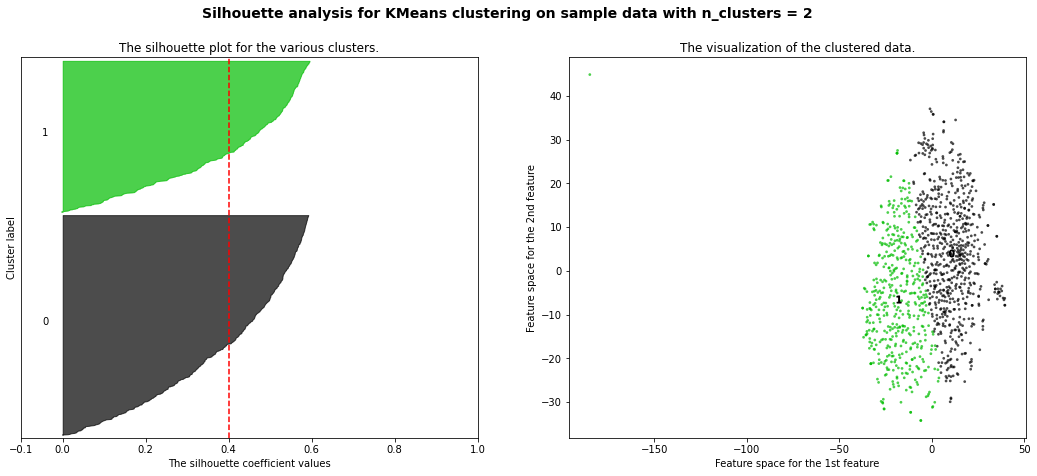

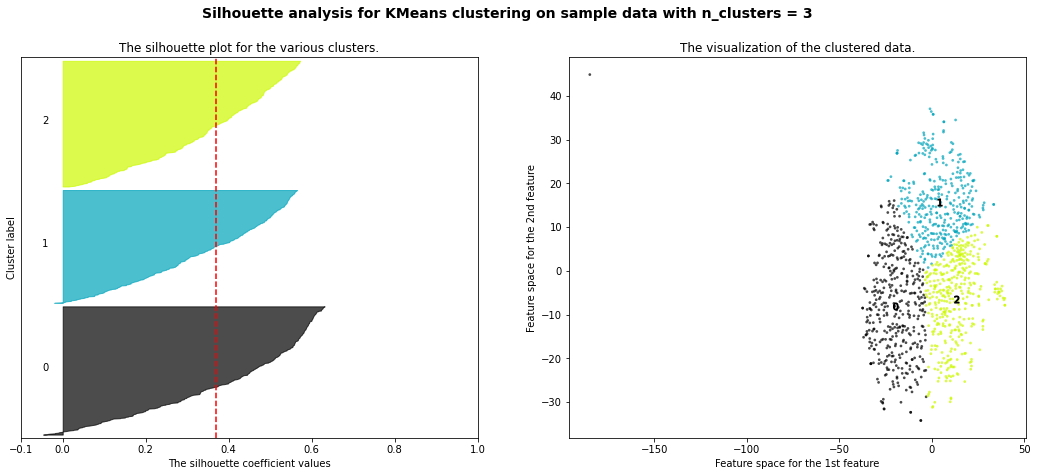

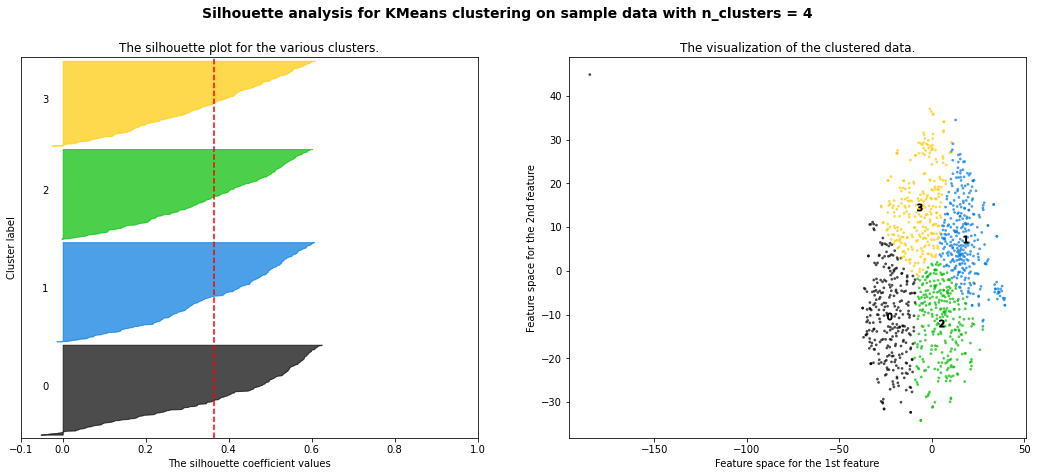

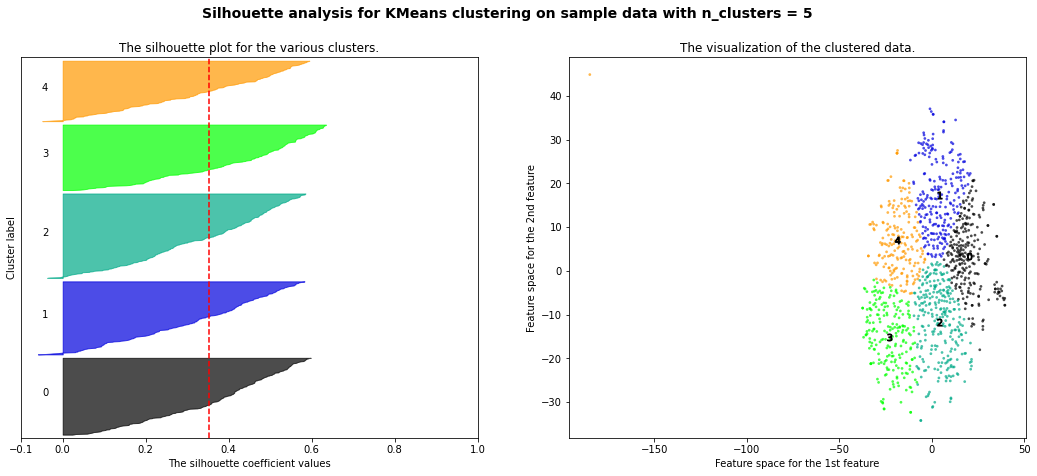

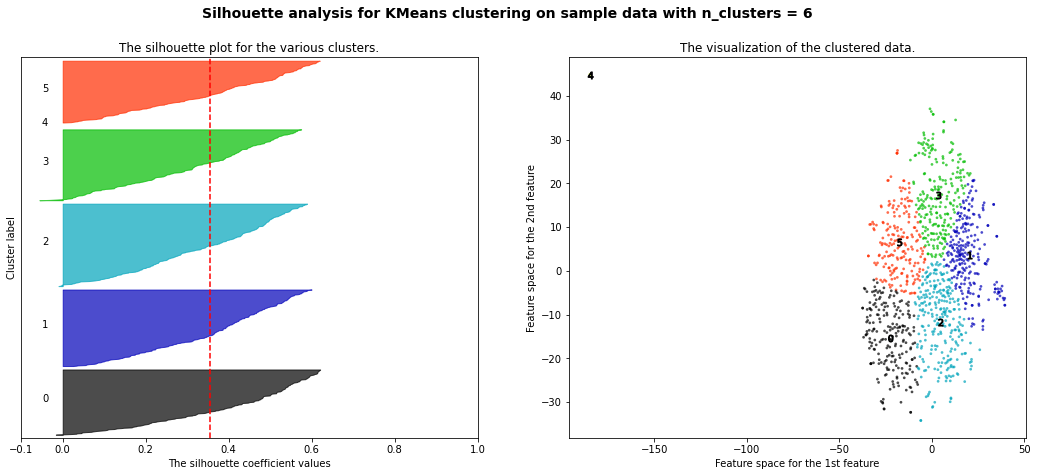

In [12]:
Visualize(np_X,10,1)

For n_clusters = 2 The average silhouette_score is : 0.7549603439278455
Silhouetter Score: 0.755
For n_clusters = 3 The average silhouette_score is : 0.6975232617220525
Silhouetter Score: 0.698
For n_clusters = 4 The average silhouette_score is : 0.7024663281996917
Silhouetter Score: 0.702
For n_clusters = 5 The average silhouette_score is : 0.5883601747550967
Silhouetter Score: 0.588
For n_clusters = 6 The average silhouette_score is : 0.5793871373499979
Silhouetter Score: 0.579


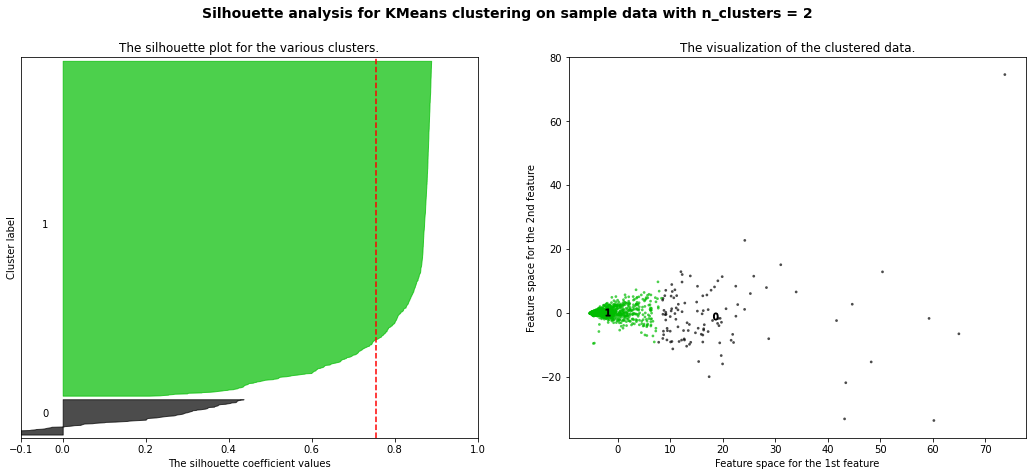

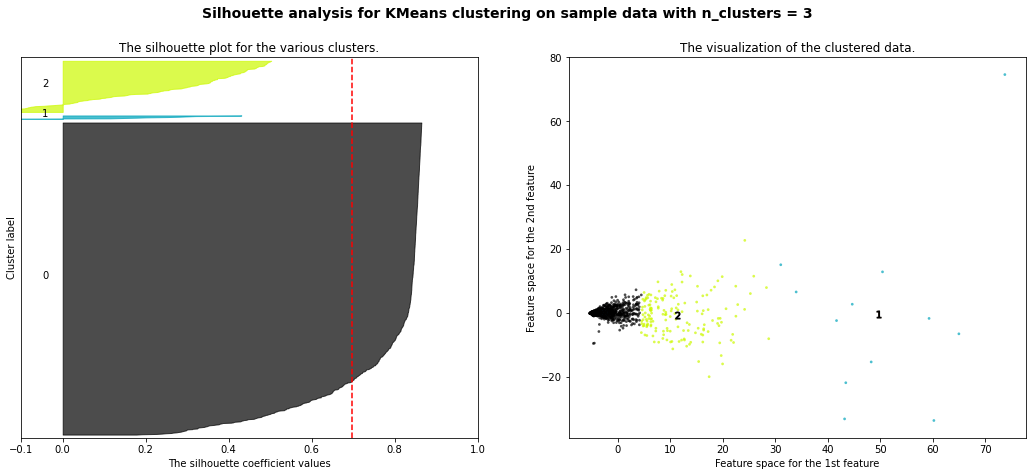

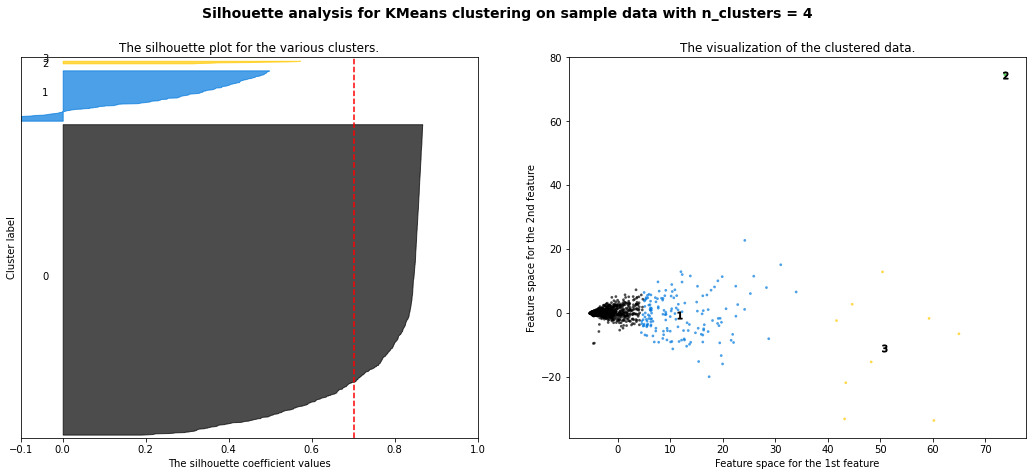

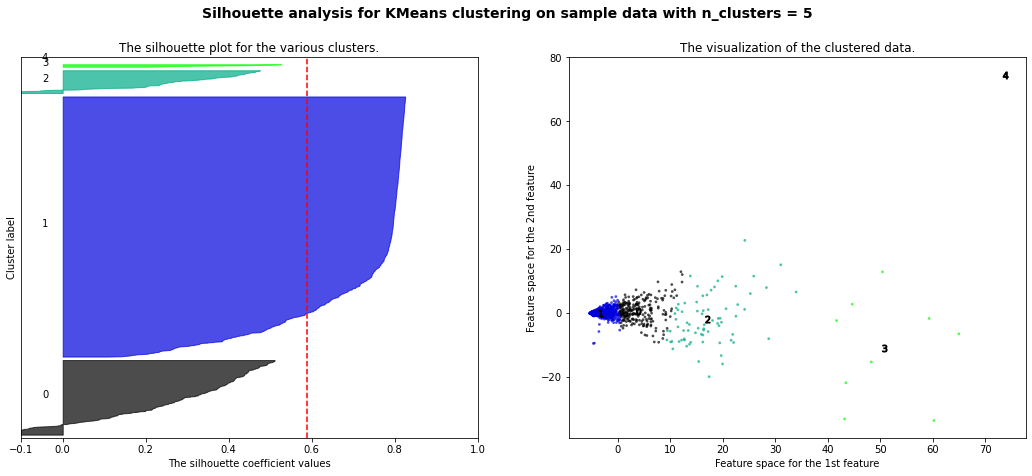

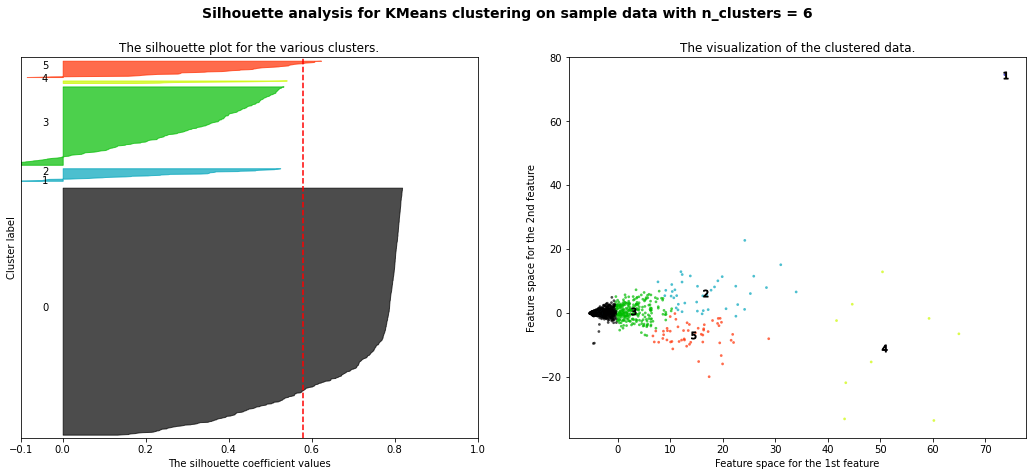

In [13]:
Visualize(np_X,10,0)